In [6]:
import os
import ipynb
import warnings
from IPython.utils import io

from sklearn.exceptions import FitFailedWarning, ConvergenceWarning 

import numpy as np
import pandas as pd
import seaborn as sns

import statistics
from scipy.stats import loguniform

from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, RandomizedSearchCV
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.utils._testing import ignore_warnings 
from sklearn.metrics import classification_report

from ipynb.fs.full.preprocessing import preprocessing #import preprocessing class from preprocessing.ipynb
from ipynb.fs.full.accuracy_plots import cumulative_acc_plot #import fx from accuracy_plots.ipynb
from ipynb.fs.full.accuracy_plots import accuracy_by_nfeatures #import fx from accuracy_plots.ipynb

In [7]:
#option 1: call preprocessing class to generate dataframes
prep_dwt = preprocessing(file_path = '/Users/jhbyun/Documents/685-Pr/ovarian-cancer-classification/data/DWT.csv') #initialize class for DWT_8702
dwt = prep_dwt.label_df() #generate dataframe with labels

prep_wang = preprocessing(file_path = '/Users/jhbyun/Documents/685-Pr/ovarian-cancer-classification/data/Wang.csv') #initialize class for WPD_Wang_8702
wang = prep_wang.label_df()

prep_jones = preprocessing(file_path = '/Users/jhbyun/Documents/685-Pr/ovarian-cancer-classification/data/Jones.csv') #initialize class for WPD_Wang_8702
jones = prep_jones.label_df()

'''
#option 2: restore dataframes if previously stored in 00_EDA.ipynb
%store -r dwt8 
dwt8 = dwt8

%store -r wp8
wp8 = wp8
'''

'\n#option 2: restore dataframes if previously stored in 00_EDA.ipynb\n%store -r dwt8 \ndwt8 = dwt8\n\n%store -r wp8\nwp8 = wp8\n'

## Logistic Regression (balanced sampling, default parameters)

In [43]:
def log_reg_default(df, n_iter=1000):

    df = df

    subset_0 = df[df['state'] == 0]
    subset_1 = df[df['state'] == 1]

    subset_1 = subset_1.sample(n=91) #randomly sample cases to match number of controls
    df = pd.concat([subset_0, subset_1])
                     
    x = df.loc[:, df.columns != 'state'] #features
    y = df.loc[:, df.columns == 'state'] #supervisor

    eval_metrics = { #empty dictionary to store classification report
        '0_precision': [],
        '0_recall': [],
        '0_f1-score': [],
        '0_support': [],

        '1_precision': [],
        '1_recall': [],
        '1_f1-score': [],
        '1_support': [],
        
        'accuracy': [],
        'accuracy_train': [],
    }

    for i in range(n_iter): 

        x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.67)

        scaler = StandardScaler()    
        scaler.fit(x_train)
        x_train = scaler.transform(x_train)
        x_test = scaler.transform(x_test)

        log_reg_model = LogisticRegression() 
        log_reg_model.fit(x_train, y_train.values.ravel())
        
        y_pred = log_reg_model.predict(x_test)
        report = classification_report(y_test, y_pred, output_dict=True)

        y_pred_train = log_reg_model.predict(x_train)
        report_train = classification_report(y_train, y_pred_train, output_dict=True)

        eval_metrics['0_precision'].append(report['0']['precision']) #store classification_report values in dictionary
        eval_metrics['0_recall'].append(report['0']['recall'])
        eval_metrics['0_f1-score'].append(report['0']['f1-score'])
        eval_metrics['0_support'].append(report['0']['support'])

        eval_metrics['1_precision'].append(report['1']['precision'])
        eval_metrics['1_recall'].append(report['1']['recall'])
        eval_metrics['1_f1-score'].append(report['1']['f1-score'])
        eval_metrics['1_support'].append(report['1']['support'])

        eval_metrics['accuracy'].append(report['accuracy'])
        eval_metrics['accuracy_train'].append(report_train['accuracy'])

    eval_metrics_df = pd.DataFrame.from_dict(eval_metrics) #convert dictionary to dataframe

    return eval_metrics_df

In [6]:
lr_default_acc_dwt = log_reg_default(dwt, n_iter=1000)
lr_default_acc_wang = log_reg_default(wang, n_iter=1000)
lr_default_acc_jones = log_reg_default(jones, n_iter=1000)

In [7]:
print('DWT Method Accuracy ', round(lr_default_acc_dwt['accuracy'].mean(), 4))
print('Wang Method Accuracy ', round(lr_default_acc_wang['accuracy'].mean(), 4))
print('Jones Method Accuracy ', round(lr_default_acc_jones['accuracy'].mean(), 4))

DWT Method Accuracy  0.943
Wang Method Accuracy  0.9577
Jones Method Accuracy  0.8938


### Cumulative Accuracy Plot Function

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Logistic Regression with Default Parameters for Jones'}, xlabel='nth Sampling Iteration', ylabel='Accuracy'>)

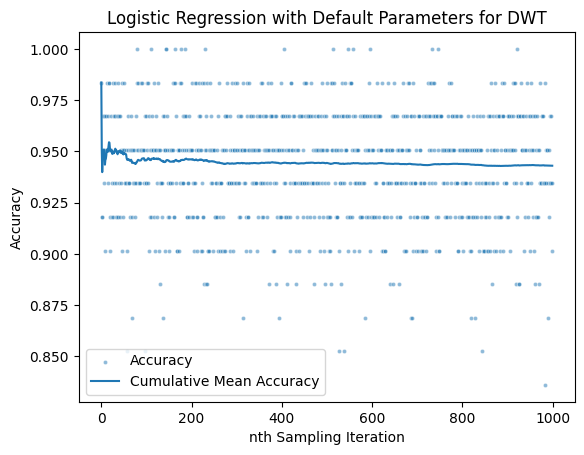

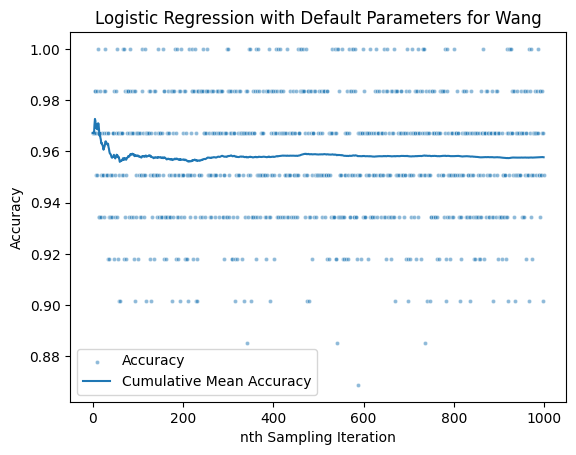

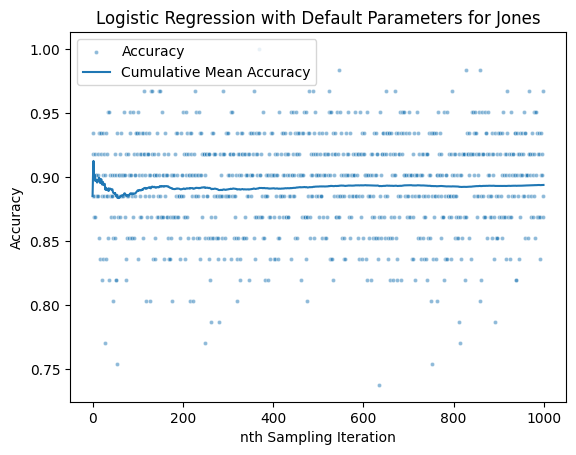

In [10]:
#calling imported function from accuracy_plots.ipynb
cumulative_acc_plot(classifier_name = 'Logistic Regression',
                    df=lr_default_acc_dwt, 
                    df_name='DWT',
                    method='Default Parameters') 

cumulative_acc_plot(classifier_name = 'Logistic Regression',
                    df=lr_default_acc_wang, 
                    df_name='Wang',
                    method='Default Parameters') 

cumulative_acc_plot(classifier_name = 'Logistic Regression',
                    df=lr_default_acc_jones, 
                    df_name='Jones',
                    method='Default Parameters') 

## Logistic Regression (random search)

In [25]:
@ignore_warnings(category=(ConvergenceWarning, FitFailedWarning, UserWarning)) #ignore warnings for forbidden parameter combinations between solvers and penalty in grid
def log_reg_random(df, n_iter=100): 

    df = df

    subset_0 = df[df['state'] == 0]
    subset_1 = df[df['state'] == 1]

    subset_1 = subset_1.sample(n=91) #randomly sample cases to match number of controls
    df = pd.concat([subset_0, subset_1])

    x = df.loc[:, df.columns != 'state'] #features
    y = df.loc[:, df.columns == 'state'] #supervisor

    eval_metrics = { #empty dictionary to store classification report
        '0_precision': [],
        '0_recall': [],
        '0_f1-score': [],
        '0_support': [],

        '1_precision': [],
        '1_recall': [],
        '1_f1-score': [],
        '1_support': [],
        
        'accuracy': [],
        'accuracy_train': [],

    }

    for i in range(n_iter): 

        x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.67)

        scaler = StandardScaler()
        log_reg_model = LogisticRegression(max_iter=1000)
        param_grid = {
            'log_reg__solver': ['newton-cg', 'lbfgs', 'liblinear'],
            'log_reg__penalty': ['l1', 'l2', 'elasticnet'],
            'log_reg__C': loguniform(1e-5, 100)
        }
        
        cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=1) 
        pipeline = Pipeline(steps=[("scaler", scaler), ("log_reg", log_reg_model)])
        search = RandomizedSearchCV(pipeline, param_grid, n_iter=50, scoring='accuracy', n_jobs=-1, cv=cv) #n_iter = number of parameter settings that are sampled
        
        result = search.fit(x_train, y_train.values.ravel())
        y_pred = result.predict(x_test)
        report = classification_report(y_test, y_pred, output_dict=True)

        y_pred_train = result.predict(x_train)
        report_train = classification_report(y_train, y_pred_train, output_dict=True)

        eval_metrics['0_precision'].append(report['0']['precision']) #store classification_report values in dictionary
        eval_metrics['0_recall'].append(report['0']['recall'])
        eval_metrics['0_f1-score'].append(report['0']['f1-score'])
        eval_metrics['0_support'].append(report['0']['support'])

        eval_metrics['1_precision'].append(report['1']['precision'])
        eval_metrics['1_recall'].append(report['1']['recall'])
        eval_metrics['1_f1-score'].append(report['1']['f1-score'])
        eval_metrics['1_support'].append(report['1']['support'])

        eval_metrics['accuracy'].append(report['accuracy'])
        eval_metrics['accuracy_train'].append(report_train['accuracy'])

    eval_metrics_df = pd.DataFrame.from_dict(eval_metrics) #convert dictionary to dataframe

    return eval_metrics_df

In [67]:
lr_random_acc_dwt = log_reg_random(dwt, n_iter=500)
lr_random_acc_wang = log_reg_random(wang, n_iter=500)
lr_random_acc_jones = log_reg_random(jones, n_iter=500)

In [68]:
print('DWT Method Accuracy ', round(lr_random_acc_dwt['accuracy'].mean(), 4))
print('Wang Method Accuracy ', round(lr_random_acc_wang['accuracy'].mean(), 4))
print('Jones Method Accuracy ', round(lr_random_acc_jones['accuracy'].mean(), 4))

DWT Method Accuracy  0.941
Wang Method Accuracy  0.9514
Jones Method Accuracy  0.8889


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Logistic Regression with Random Search for Jones'}, xlabel='nth Sampling Iteration', ylabel='Accuracy'>)

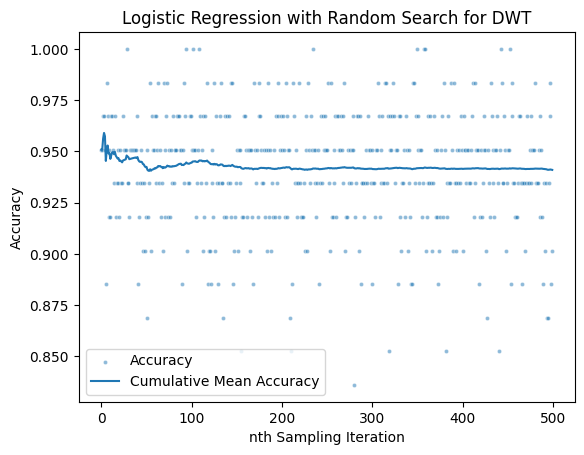

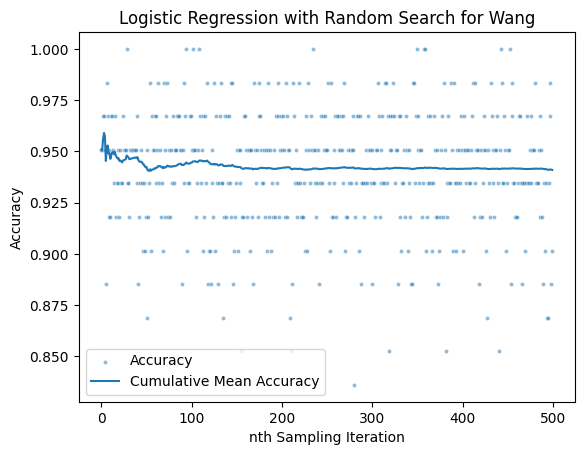

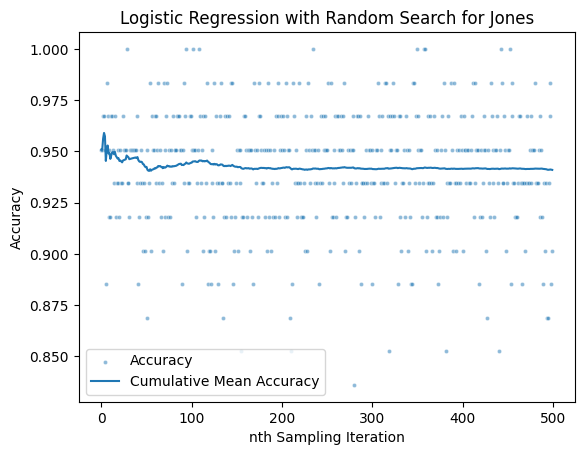

In [69]:
#calling imported function from accuracy_plots.ipynb
cumulative_acc_plot(classifier_name = 'Logistic Regression',
                    df=lr_random_acc_dwt, 
                    df_name='DWT',
                    method='Random Search') 

cumulative_acc_plot(classifier_name = 'Logistic Regression',
                    df=lr_random_acc_wang, 
                    df_name='Wang',
                    method='Random Search') 

cumulative_acc_plot(classifier_name = 'Logistic Regression',
                    df=lr_random_acc_jones, 
                    df_name='Jones',
                    method='Random Search') 

## Accuracy by files and n Fisher's features

### Logistic Regression: Default Parameters

In [32]:
lr_default_acc_metrics_dwt = accuracy_by_nfeatures(
                    class_instance=prep_dwt, file_name='DWT', classifier=log_reg_default, n_features=29, n_iter=500)
lr_default_acc_metrics_wang = accuracy_by_nfeatures(
                    class_instance=prep_wang, file_name='Wang', classifier=log_reg_default, n_features=29, n_iter=500)
lr_default_acc_metrics_jones = accuracy_by_nfeatures(
                    class_instance=prep_jones, file_name='Jones', classifier=log_reg_default, n_features=29, n_iter=500)

In [33]:
lr_default_acc_metrics_dwt = lr_default_acc_metrics_dwt.rename(
                                columns = lambda col: f"{col}_dwt" 
                                if col not in ('n_features', 'file_name') else col)

lr_default_acc_metrics_wang = lr_default_acc_metrics_wang.rename(
                                columns = lambda col: f"{col}_wang" 
                                if col not in ('n_features', 'file_name') else col)

lr_default_acc_metrics_jones = lr_default_acc_metrics_jones.rename(
                                columns = lambda col: f"{col}_jones" 
                                if col not in ('n_features', 'file_name') else col)     

In [34]:
#merge three dataframes on n_features
merged_logreg_default = lr_default_acc_metrics_dwt.merge(lr_default_acc_metrics_wang, how='right', on='n_features').merge(lr_default_acc_metrics_jones, how='right', on='n_features')
merged_logreg_default.head()

,n_features,file_name_x,mean_dwt,stdev_dwt,mean_train_dwt,stdev_train_dwt,file_name_y,mean_wang,stdev_wang,mean_train_wang,stdev_train_wang,file_name,mean_jones,stdev_jones,mean_train_jones,stdev_train_jones
0,1,DWT,0.797082,0.04241,0.806248,0.022877,Wang,0.793443,0.045358,0.798298,0.024476,Jones,0.749672,0.046126,0.754545,0.029784
1,2,DWT,0.873115,0.037104,0.881157,0.019792,Wang,0.875213,0.03494,0.880066,0.018151,Jones,0.805016,0.045885,0.81514,0.02637
2,3,DWT,0.931803,0.030269,0.937587,0.013692,Wang,0.89659,0.031621,0.907769,0.022159,Jones,0.796164,0.046105,0.812314,0.024727
3,4,DWT,0.923148,0.028998,0.942678,0.012975,Wang,0.906098,0.030953,0.92438,0.019323,Jones,0.822328,0.041057,0.84795,0.021762
4,5,DWT,0.938066,0.02441,0.951917,0.01329,Wang,0.918721,0.028819,0.939174,0.016772,Jones,0.815344,0.043634,0.837752,0.022735


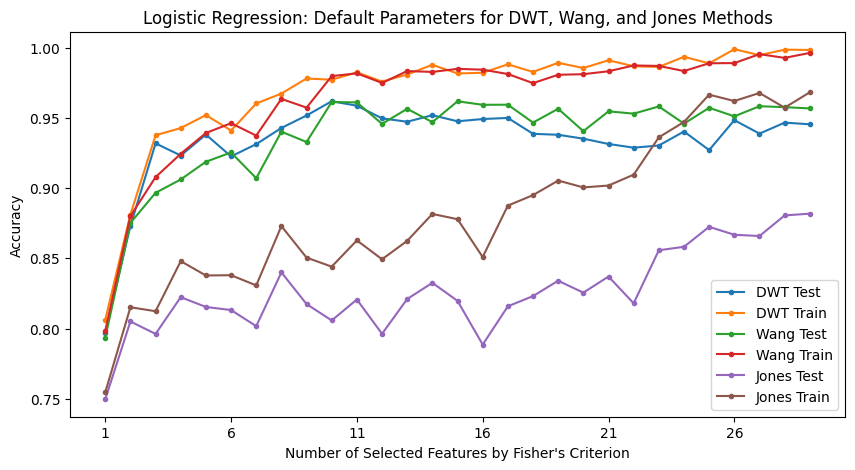

In [36]:
merged_logreg_default.plot(
            x='n_features', 
            y=['mean_dwt', 'mean_train_dwt', 'mean_wang', 'mean_train_wang', 'mean_jones', 'mean_train_jones'],
            marker='.', 
            title='Logistic Regression: Default Parameters for DWT, Wang, and Jones Methods',
            xlabel="Number of Selected Features by Fisher's Criterion", 
            ylabel='Accuracy', 
            figsize=(10,5))

plt.legend(['DWT Test', 'DWT Train', 'Wang Test', 'Wang Train', 'Jones Test', 'Jones Train'], loc='lower right')

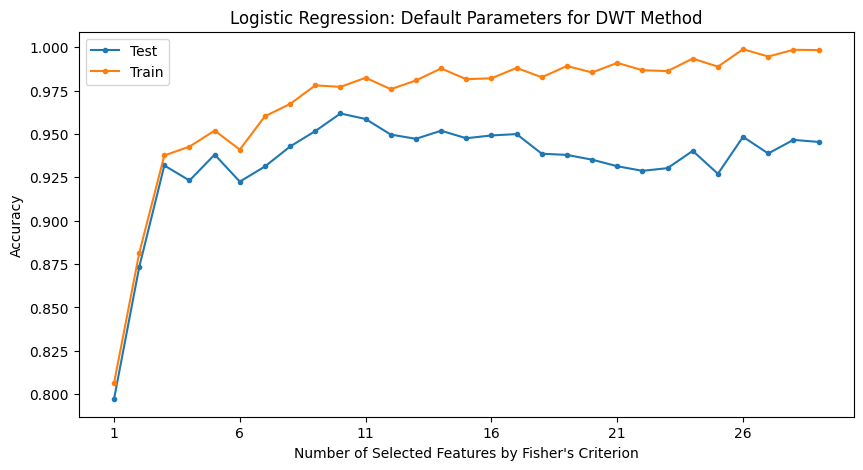

In [51]:
merged_logreg_default.plot(
            x='n_features', 
            y=['mean_dwt', 'mean_train_dwt'],
            marker='.', 
            title='Logistic Regression: Default Parameters for DWT Method',
            xlabel="Number of Selected Features by Fisher's Criterion", 
            ylabel='Accuracy', 
            figsize=(10,5))

plt.legend(['Test', 'Train'])

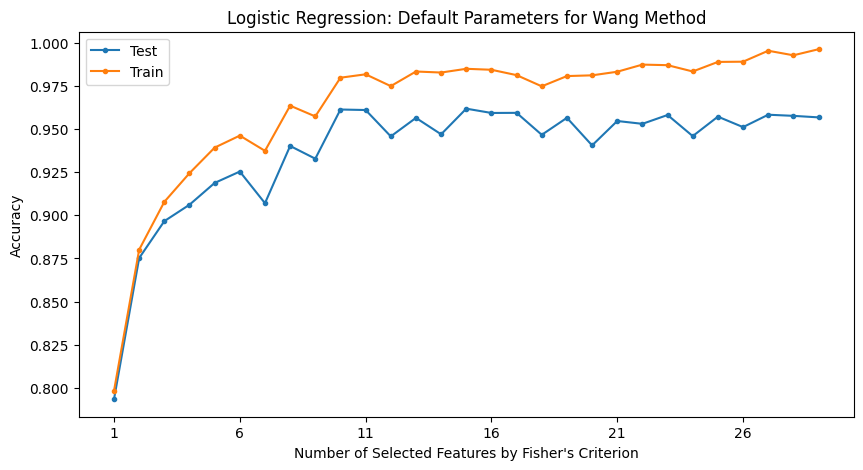

In [52]:
merged_logreg_default.plot(
            x='n_features', 
            y=['mean_wang', 'mean_train_wang'],
            marker='.', 
            title='Logistic Regression: Default Parameters for Wang Method',
            xlabel="Number of Selected Features by Fisher's Criterion", 
            ylabel='Accuracy', 
            figsize=(10,5))

plt.legend(['Test', 'Train'])

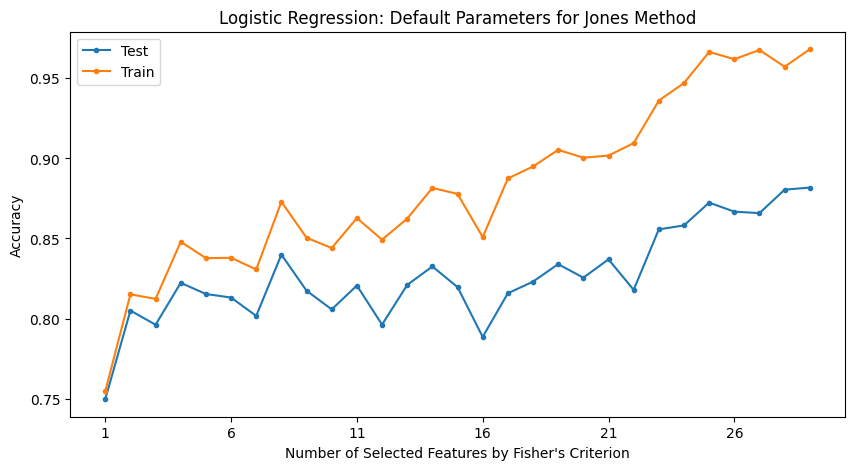

In [53]:
merged_logreg_default.plot(
            x='n_features', 
            y=['mean_jones', 'mean_train_jones'],
            marker='.', 
            title='Logistic Regression: Default Parameters for Jones Method',
            xlabel="Number of Selected Features by Fisher's Criterion", 
            ylabel='Accuracy', 
            figsize=(10,5))

plt.legend(['Test', 'Train'])

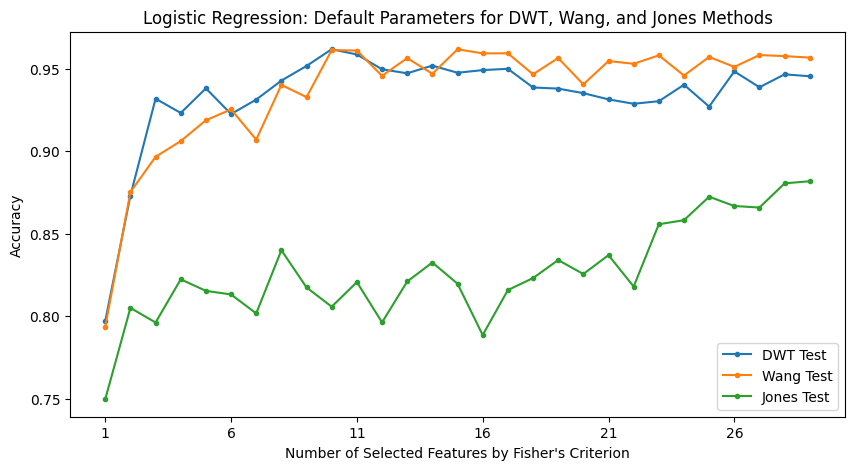

In [54]:
#test sets only 
merged_logreg_default.plot(
            x='n_features', 
            y=['mean_dwt', 'mean_wang', 'mean_jones'],
            marker='.', 
            title='Logistic Regression: Default Parameters for DWT, Wang, and Jones Methods',
            xlabel="Number of Selected Features by Fisher's Criterion", 
            ylabel='Accuracy', 
            figsize=(10,5))

plt.legend(['DWT Test', 'Wang Test', 'Jones Test'], loc='lower right')

### Logistic Regression: Random Search

In [69]:
lr_random_acc_metrics_dwt = accuracy_by_nfeatures(
                    class_instance=prep_dwt, file_name='DWT', classifier=log_reg_random, n_features=29, n_iter=200)
lr_random_acc_metrics_wang = accuracy_by_nfeatures(
                    class_instance=prep_wang, file_name='Wang', classifier=log_reg_random, n_features=29, n_iter=200)
lr_random_acc_metrics_jones = accuracy_by_nfeatures(
                    class_instance=prep_jones, file_name='Jones', classifier=log_reg_random, n_features=29, n_iter=200)

In [70]:
lr_random_acc_metrics_dwt = lr_random_acc_metrics_dwt.rename(
                                columns = lambda col: f"{col}_dwt" 
                                if col not in ('n_features', 'file_name') else col)

lr_random_acc_metrics_wang = lr_random_acc_metrics_wang.rename(
                                columns = lambda col: f"{col}_wang" 
                                if col not in ('n_features', 'file_name') else col)

lr_random_acc_metrics_jones = lr_random_acc_metrics_jones.rename(
                                columns = lambda col: f"{col}_jones" 
                                if col not in ('n_features', 'file_name') else col)     

In [71]:
#merge three dataframes on n_features
merged_logreg_random = lr_random_acc_metrics_dwt.merge(lr_random_acc_metrics_wang, how='right', on='n_features').merge(lr_random_acc_metrics_jones, how='right', on='n_features')
merged_logreg_random.head()

,n_features,file_name_x,mean_dwt,stdev_dwt,mean_train_dwt,stdev_train_dwt,file_name_y,mean_wang,stdev_wang,mean_train_wang,stdev_train_wang,file_name,mean_jones,stdev_jones,mean_train_jones,stdev_train_jones
0,1,DWT,0.787131,0.041331,0.800331,0.021098,Wang,0.771967,0.045521,0.79124,0.022648,Jones,0.755984,0.047324,0.764876,0.025453
1,2,DWT,0.877049,0.033156,0.887066,0.018771,Wang,0.879016,0.039015,0.891901,0.018384,Jones,0.788443,0.0435,0.80562,0.024112
2,3,DWT,0.905902,0.029821,0.924174,0.014313,Wang,0.916967,0.027991,0.932314,0.017854,Jones,0.774672,0.047233,0.80062,0.02571
3,4,DWT,0.930164,0.029775,0.944174,0.014529,Wang,0.886148,0.030134,0.912975,0.016795,Jones,0.797131,0.044295,0.818884,0.023166
4,5,DWT,0.92877,0.028351,0.945124,0.014279,Wang,0.925492,0.02888,0.943099,0.013466,Jones,0.819262,0.045498,0.84595,0.021764


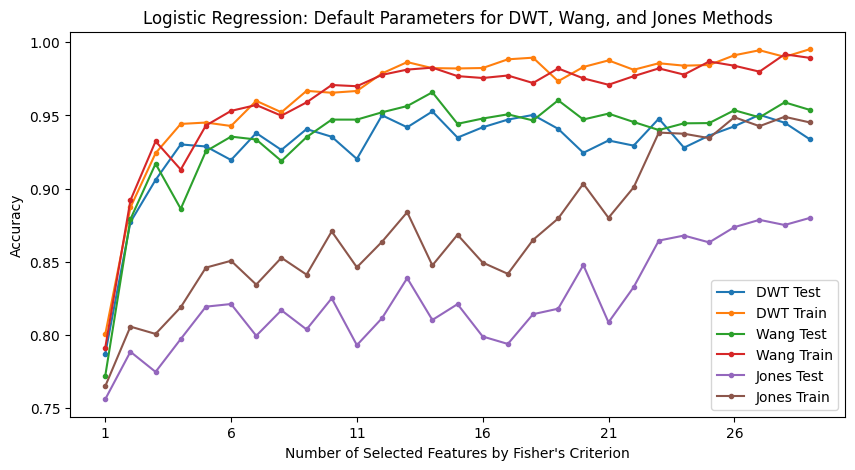

In [74]:
merged_logreg_random.plot(
            x='n_features', 
            y=['mean_dwt', 'mean_train_dwt', 'mean_wang', 'mean_train_wang', 'mean_jones', 'mean_train_jones'],
            marker='.', 
            title='Logistic Regression: Default Parameters for DWT, Wang, and Jones Methods',
            xlabel="Number of Selected Features by Fisher's Criterion", 
            ylabel='Accuracy', 
            figsize=(10,5))

plt.legend(['DWT Test', 'DWT Train', 'Wang Test', 'Wang Train', 'Jones Test', 'Jones Train'], loc='lower right')

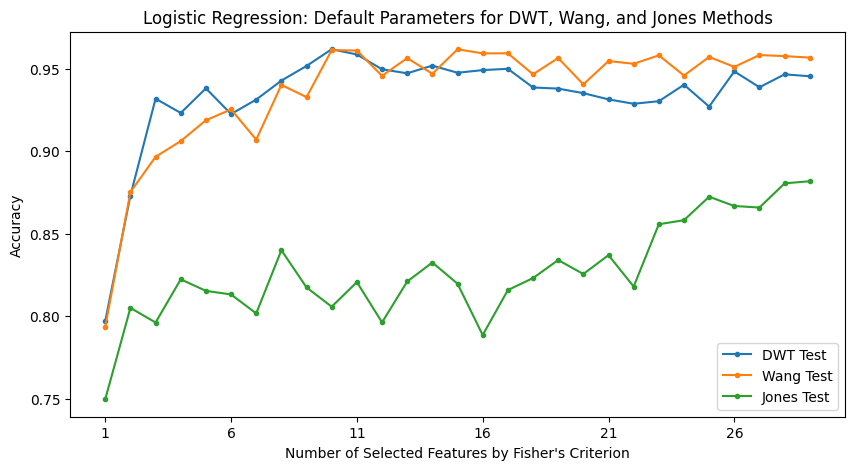

In [75]:
#test sets only 
merged_logreg_default.plot(
            x='n_features', 
            y=['mean_dwt', 'mean_wang', 'mean_jones'],
            marker='.', 
            title='Logistic Regression: Default Parameters for DWT, Wang, and Jones Methods',
            xlabel="Number of Selected Features by Fisher's Criterion", 
            ylabel='Accuracy', 
            figsize=(10,5))

plt.legend(['DWT Test', 'Wang Test', 'Jones Test'], loc='lower right')

In [298]:
#merge two dataframes on n_features
merged_logreg_randsearch = acc_metrics_dwt8.merge(acc_metrics_wp8, how='right', on='n_features', suffixes=('_dwt8', '_wp8')) 
merged_logreg_randsearch.head()

,n_features,file_name_dwt8,mean_dwt8,stdev_dwt8,mean_train_dwt8,stdev_train_dwt8,file_name_wp8,mean_wp8,stdev_wp8,mean_train_wp8,stdev_train_wp8
0,1,DWT_8702,0.77877,0.036149,0.785937,0.017754,WPD_Wang_8702,0.77246,0.041056,0.782525,0.020932
1,2,DWT_8702,0.872619,0.033959,0.882367,0.018484,WPD_Wang_8702,0.869802,0.028651,0.875996,0.014111
2,3,DWT_8702,0.910079,0.025109,0.92215,0.012,WPD_Wang_8702,0.899206,0.03011,0.91426,0.018589
3,4,DWT_8702,0.919762,0.023926,0.934536,0.012849,WPD_Wang_8702,0.903056,0.029874,0.916588,0.017623
4,5,DWT_8702,0.925873,0.024463,0.939783,0.013436,WPD_Wang_8702,0.929405,0.02181,0.944852,0.013188


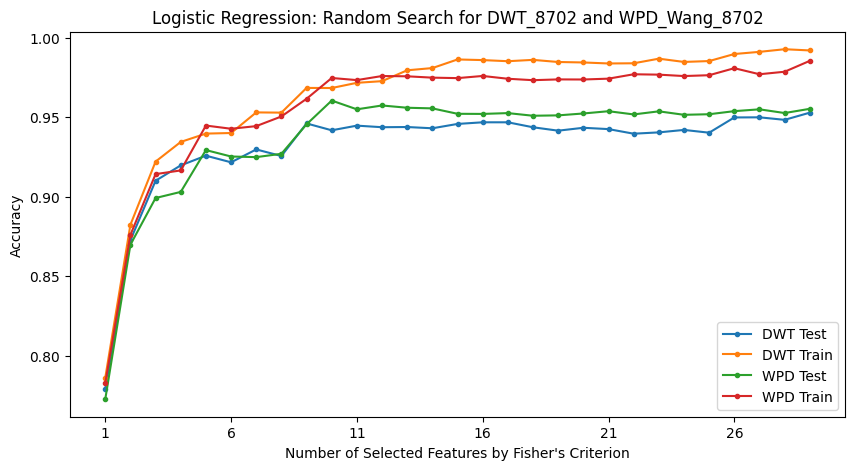

In [299]:
merged_logreg_randsearch.plot(x='n_features', y=['mean_dwt8', 'mean_train_dwt8', 'mean_wp8', 'mean_train_wp8',], marker='.', 
           title='Logistic Regression: Random Search for DWT_8702 and WPD_Wang_8702',
           xlabel="Number of Selected Features by Fisher's Criterion", ylabel='Accuracy', 
           figsize=(10,5))

plt.legend(['DWT Test', 'DWT Train', 'WPD Test', 'WPD Train'], loc='lower right')

## Logistic Regression: forward selection

In [14]:
def log_reg_selection(df, n_iter = 100, n_features=10): 

    feature_arr = [] #empty array to store selected features
    df = df

    subset_0 = df[df['state'] == 0]
    subset_1 = df[df['state'] == 1]

    subset_1 = subset_1.sample(n=91) #randomly sample cases to match number of controls
    df = pd.concat([subset_0, subset_1])

    x = df.loc[:, df.columns != 'state'] #features
    y = df.loc[:, df.columns == 'state'] #supervisor

    eval_metrics = { #empty dictionary to store classification report
        '0_precision': [],
        '0_recall': [],
        '0_f1-score': [],
        '0_support': [],

        '1_precision': [],
        '1_recall': [],
        '1_f1-score': [],
        '1_support': [],
        
        'accuracy': [],
    } 

    for i in range(n_iter): 

        x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.67)
        
        scaler = StandardScaler()
        scaler.fit(x_train)
        x_train = scaler.transform(x_train)
        x_test = scaler.transform(x_test) 

        log_reg_model = LogisticRegression(max_iter=500, penalty=None) #no penalty/regularization since feature selection performed, defaults for everything else
        cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=1)
        sfs = SequentialFeatureSelector(log_reg_model, direction='forward', scoring='accuracy', 
                                        n_features_to_select=n_features, cv=cv, n_jobs=-1)
    
        result = sfs.fit(x_train, y_train.values.ravel()) #fit with SequentialFeatureSelector
        #print(result.get_feature_names_out()) #print array of selected features
        x_train_sel = result.transform(x_train) #reduce training set to the selected features
        x_test_sel = result.transform(x_test) #reduce test set to the selected features

        sel_features_idx = sfs.get_support() #get boolean list of selected features
        sel_features = x.columns[sel_features_idx] #get column names of selected features
        feature_arr.append(sel_features) #store selected features in array

        result = log_reg_model.fit(x_train_sel, y_train.values.ravel()) #fit logistic regression model with filtered training set
        y_pred = result.predict(x_test_sel) #generate predictions with filtered test set
        report = classification_report(y_test, y_pred, output_dict=True) #generate classification report from test set 

        eval_metrics['0_precision'].append(report['0']['precision']) #store classification_report values in dictionary
        eval_metrics['0_recall'].append(report['0']['recall'])
        eval_metrics['0_f1-score'].append(report['0']['f1-score'])
        eval_metrics['0_support'].append(report['0']['support'])

        eval_metrics['1_precision'].append(report['1']['precision'])
        eval_metrics['1_recall'].append(report['1']['recall'])
        eval_metrics['1_f1-score'].append(report['1']['f1-score'])
        eval_metrics['1_support'].append(report['1']['support'])

        eval_metrics['accuracy'].append(report['accuracy'])

    eval_metrics_df = pd.DataFrame.from_dict(eval_metrics) #convert dictionary to dataframe

    feature_arr = np.asarray(feature_arr) #convert list to np array
    feature_arr_flat = np.ravel(feature_arr) #flatten np array

    return eval_metrics_df, feature_arr_flat

### DWT

In [30]:
acc_df_forward_dwt, feature_arr_flat_dwt = log_reg_selection(dwt, n_iter=100, n_features=10) #run forward feature selection for dwt8, 10 features

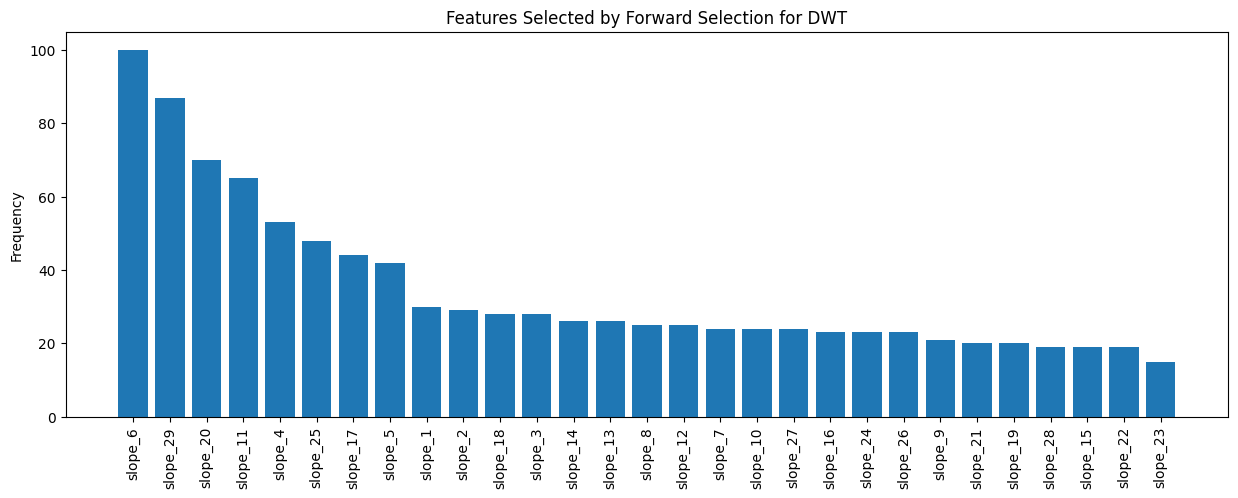

In [31]:
feature_count_arr_dwt = np.unique(feature_arr_flat_dwt, return_counts=True)
feature_count_df_dwt = pd.DataFrame(feature_count_arr_dwt).T
feature_count_df_dwt.columns = ['feature', 'frequency']
feature_count_df_dwt = feature_count_df_dwt.sort_values('frequency', ascending=False)
feature_count_top10_dwt = feature_count_df_dwt.head(10) #top 10 features by frequency

plt.figure(figsize=(15,5))
plt.bar(feature_count_df_dwt['feature'], feature_count_df_dwt['frequency'])
plt.title("Features Selected by Forward Selection for DWT")
plt.ylabel("Frequency")
plt.xticks(rotation=90)
plt.show()

In [32]:
top10_features = feature_count_top10_dwt['feature'].tolist()
top10_features.append('state') 

dwt_forward_filtered = dwt.loc[:,top10_features] #filter dwt dataframe to only include top 10 features
dwt_forward_filtered.head()

,slope_6,slope_29,slope_20,slope_11,slope_4,slope_25,slope_17,slope_5,slope_1,slope_2,state
0,-2.853814,-2.390560,-2.931648,-2.409633,-2.567832,-2.868000,-2.747051,-2.714483,-2.462234,-2.390083,1
1,-2.664095,-2.344442,-3.017540,-2.428556,-2.322088,-2.815763,-2.825209,-2.544736,-2.303016,-2.243269,1
2,-2.848399,-2.603805,-3.043497,-2.089429,-2.477289,-2.872999,-2.786237,-2.450869,-2.378106,-2.286579,1
3,-2.738331,-2.401006,-3.056333,-1.990729,-2.373840,-2.847411,-2.546528,-2.467567,-2.411076,-2.357384,1
4,-2.718791,-2.421083,-3.051181,-1.712213,-2.333251,-2.842104,-2.619271,-2.608106,-2.382939,-2.423288,1


In [33]:
acc_df_dwt_forward_filtered = log_reg_random(dwt_forward_filtered, n_iter=100) #run random search for filtered dataframe

print(round(acc_df_dwt_forward_filtered['accuracy'].mean(), 4)) #mean accuracy for forward selection filtered dataframe

0.9584


### Wang

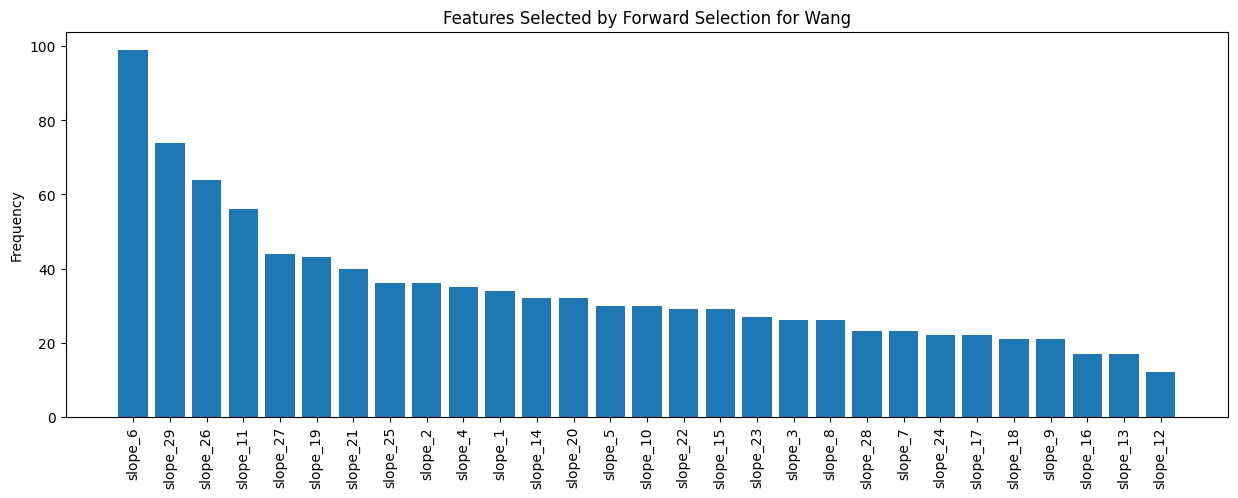

In [40]:
acc_df_forward_wang, feature_arr_flat_wang = log_reg_selection(wang, n_iter=100, n_features=10) #run forward feature selection for wang8, 10 features


feature_count_arr_wang = np.unique(feature_arr_flat_wang, return_counts=True)
feature_count_df_wang = pd.DataFrame(feature_count_arr_wang).T
feature_count_df_wang.columns = ['feature', 'frequency']
feature_count_df_wang = feature_count_df_wang.sort_values('frequency', ascending=False)
feature_count_top10_wang = feature_count_df_wang.head(10) #top 10 features by frequency


plt.figure(figsize=(15,5))
plt.bar(feature_count_df_wang['feature'], feature_count_df_wang['frequency'])
plt.title("Features Selected by Forward Selection for Wang")
plt.ylabel("Frequency")
plt.xticks(rotation=90)
plt.show()

In [42]:
top10_features = feature_count_top10_wang['feature'].tolist()
top10_features.append('state') 

wang_forward_filtered = wang.loc[:,top10_features] #filter dwt dataframe to only include top 10 features
wang_forward_filtered.head()

acc_df_wang_forward_filtered = log_reg_random(wang_forward_filtered, n_iter=100) #run random search for filtered dataframe

print(round(acc_df_wang_forward_filtered['accuracy'].mean(), 4)) #mean accuracy for forward selection filtered dataframe

0.9643


### Jones

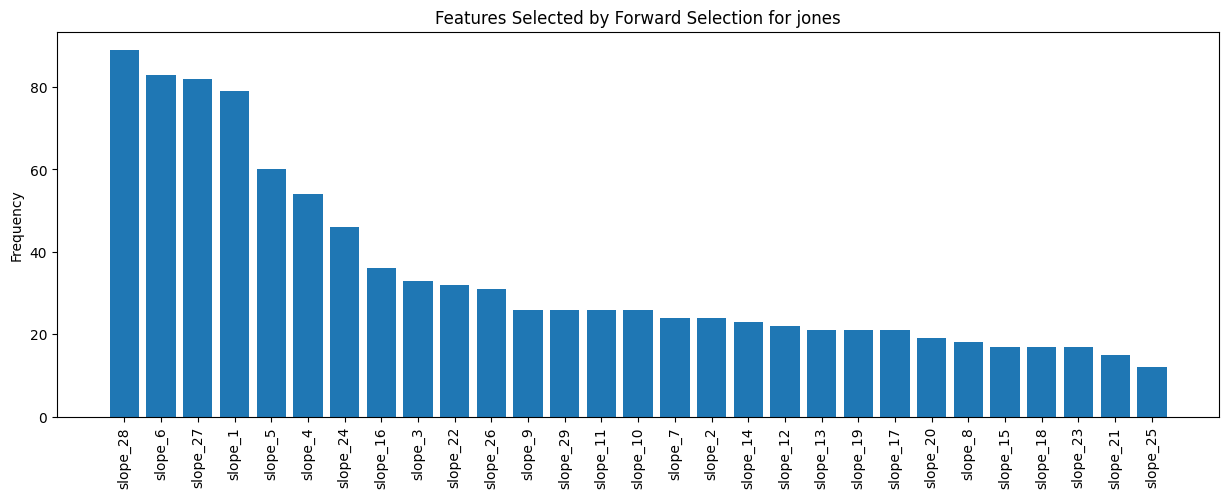

In [36]:
acc_df_forward_jones, feature_arr_flat_jones = log_reg_selection(jones, n_iter=100, n_features=10) #run forward feature selection for jones8, 10 features

feature_count_arr_jones = np.unique(feature_arr_flat_jones, return_counts=True)
feature_count_df_jones = pd.DataFrame(feature_count_arr_jones).T
feature_count_df_jones.columns = ['feature', 'frequency']
feature_count_df_jones = feature_count_df_jones.sort_values('frequency', ascending=False)
feature_count_top10_jones = feature_count_df_jones.head(10) #top 10 features by frequency

plt.figure(figsize=(15,5))
plt.bar(feature_count_df_jones['feature'], feature_count_df_jones['frequency'])
plt.title("Features Selected by Forward Selection for jones")
plt.ylabel("Frequency")
plt.xticks(rotation=90)
plt.show()

In [37]:
top10_features = feature_count_top10_jones['feature'].tolist()
top10_features.append('state')

jones_forward_filtered = jones.loc[:,top10_features] #filter dwt dataframe to only include top 10 features
jones_forward_filtered.head()

acc_df_jones_forward_filtered = log_reg_random(jones_forward_filtered, n_iter=100) #run random search for filtered dataframe

print(round(acc_df_jones_forward_filtered['accuracy'].mean(), 4)) #mean accuracy for forward selection filtered dataframe

0.9064


## Scratchpad

some of the grid parameter values are incompatible with each other (e.g. the lbfgs supports only the 'l2' or 'none' penalties, not the 'l1' penalty), so the output contains warnings whenever that happens with the randomly selected combination of parameters.

Verified that a parameter grid with no incompatible values between the solver & penalty didn't output any warnings, then suppressed the three types listed above

Which features are selected with selection? Significance of features (wilcoxon rank-sum test) compare against features selected by Fisher's criterion

DWT_8702 in progress
WPD_Wang_8702 in progress


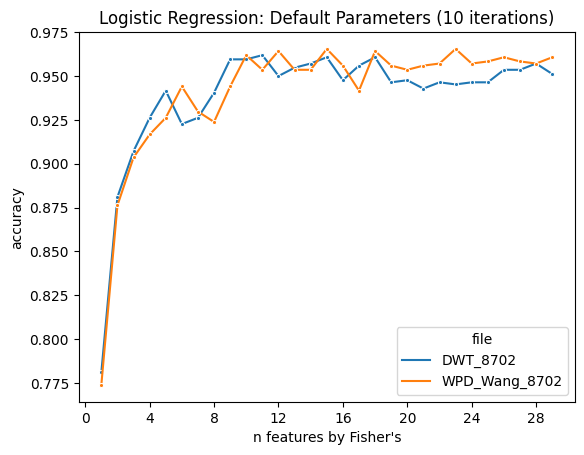

In [24]:
#full set of features, default parameters  for logistic regression
acc_metrics, pl = accuracy_plot(files = ['DWT_8702', 'WPD_Wang_8702'], #files = ['DWT_4302', 'DWT_8702', 'WPD_Wang_4302', 'WPD_Wang_8702'], 
                                default=True, n_features=29, n_iter=10)

Text(0.5, 0, "n features selected by Fisher's Criterion")

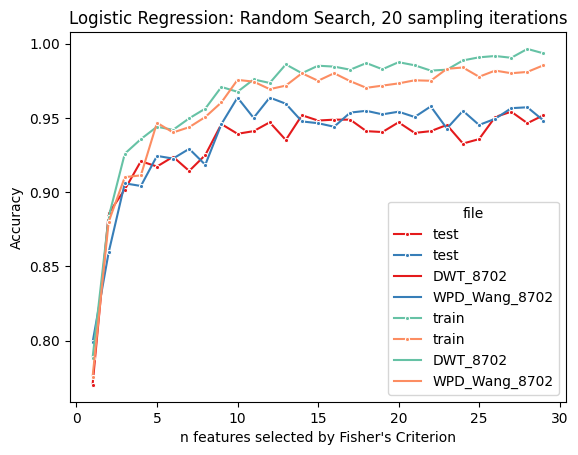

In [179]:
acc_metrics = pd.DataFrame.from_dict(acc_metrics).T
acc_metrics.columns = ['file', 'n_features', 'mean', 'stdev', 'mean_train', 'stdev_train']
acc_metrics = acc_metrics.reset_index(drop=True)

"""
#PART 2: PLOT ACCURACY METRICS FOR EACH FILE
pl = sns.lineplot(data=acc_metrics, x='n_features', y='mean', hue='file', marker='.')
pl.xaxis.set_major_locator(MaxNLocator(integer=True))
pl.set(title=(method + " (" + str(n_iter) + " iterations)"), xlabel="n features by Fisher's", ylabel='accuracy')
"""

fig, ax = plt.subplots()

sns.lineplot(data=acc_metrics, x='n_features', y='mean', hue='file', marker='.', ax=ax, palette='Set1', label='test')

sns.lineplot(data=acc_metrics, x='n_features', y='mean_train', hue='file', marker='.', ax=ax, palette='Set2', label='train')

ax.set_title('Logistic Regression: Random Search, 20 sampling iterations')
ax.set_ylabel('Accuracy')
ax.set_xlabel("n features selected by Fisher's Criterion")

#fig.set(title='Logistic Regression: Default Parameters, 1000 iterations', xlabel="n features by Fisher's", ylabel='accuracy')

In [254]:
#grid with no incompatible parameter combinations
'''
    param_grid = {
        'log_reg__solver': ['lbfgs', 'liblinear'],
        'log_reg__penalty': ['l2'],
        'log_reg__C': loguniform(1e-5, 100)
    }
    '''

"\n    param_grid = {\n        'log_reg__solver': ['lbfgs', 'liblinear'],\n        'log_reg__penalty': ['l2'],\n        'log_reg__C': loguniform(1e-5, 100)\n    }\n    "

In [272]:
def log_reg(df, n_iter=1000, tuning=['none', 'random_search', 'forward', 'backward']): #default 1k iterations

    df = df
    x = df.loc[:, df.columns != 'state'] #features
    y = df.loc[:, df.columns == 'state'] #supervisor

    eval_metrics = { #empty dictionary to store classification report
        '0_precision': [],
        '0_recall': [],
        '0_f1-score': [],
        '0_support': [],

        '1_precision': [],
        '1_recall': [],
        '1_f1-score': [],
        '1_support': [],
        
        'accuracy': [],
    }

    for i in range(n_iter): 

        x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.67)

        scaler = StandardScaler()
        log_reg_model = LogisticRegression(class_weight='balanced') #default 

        if(fishers==False): #default logistic regression params
            scaler.fit(x_train)
            x_train = scaler.transform(x_train)
            x_test = scaler.transform(x_test)

            log_reg_model.fit(x_train, y_train.values.ravel())
            y_pred = log_reg_model.predict(x_test)
        
        else: #fishers=True, random search through grid
            param_grid = {
            'log_reg__solver': ['newton-cg', 'lbfgs', 'liblinear'],
            'log_reg__penalty': ['l1', 'l2', 'elasticnet', 'None'],
            'log_reg__C': loguniform(1e-5, 100)
            }
            
            cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5)

            pipeline = Pipeline(steps=[("scaler", scaler), ("log_reg", log_reg_model)])
            search = RandomizedSearchCV(pipeline, param_grid, n_iter=100, scoring='accuracy', n_jobs=-1, cv=cv)

            result = search.fit(x_train, y_train.values.ravel())
            y_pred = result.predict(x_test)

        report = classification_report(y_test, y_pred, output_dict=True)

        eval_metrics['0_precision'].append(report['0']['precision']) #store classification_report values in dictionary
        eval_metrics['0_recall'].append(report['0']['recall'])
        eval_metrics['0_f1-score'].append(report['0']['f1-score'])
        eval_metrics['0_support'].append(report['0']['support'])

        eval_metrics['1_precision'].append(report['1']['precision'])
        eval_metrics['1_recall'].append(report['1']['recall'])
        eval_metrics['1_f1-score'].append(report['1']['f1-score'])
        eval_metrics['1_support'].append(report['1']['support'])

        eval_metrics['accuracy'].append(report['accuracy'])

    eval_metrics_df = pd.DataFrame.from_dict(eval_metrics) #convert dictionary to dataframe

    return eval_metrics_df

In [268]:
log_reg(wp8, n_iter=100)

,0_precision,0_recall,0_f1-score,0_support,1_precision,1_recall,1_f1-score,1_support,accuracy
0,0.920000,0.920000,0.920000,25,0.966102,0.966102,0.966102,59,0.952381
1,1.000000,0.941176,0.969697,34,0.961538,1.000000,0.980392,50,0.976190
2,0.935484,0.906250,0.920635,32,0.943396,0.961538,0.952381,52,0.940476
3,0.968750,0.968750,0.968750,32,0.980769,0.980769,0.980769,52,0.976190
4,0.870968,0.931034,0.900000,29,0.962264,0.927273,0.944444,55,0.928571
5,1.000000,0.909091,0.952381,33,0.944444,1.000000,0.971429,51,0.964286
6,0.972222,0.972222,0.972222,36,0.979167,0.979167,0.979167,48,0.976190
7,1.000000,0.968750,0.984127,32,0.981132,1.000000,0.990476,52,0.988095
8,0.903226,0.933333,0.918033,30,0.962264,0.944444,0.953271,54,0.940476
9,1.000000,0.812500,0.896552,32,0.896552,1.000000,0.945455,52,0.928571


#### 1A. Wavelet Packet / Wang, 8-7-02 data (wp8)

#### 1B. Discrete Wavelet Transform, 8-7-02 data (dwt8)

#### 2A. Wavelet Packet / Wang, 8-7-02 data (wp8)

#### 2B. Discrete Wavelet Transform, 8-7-02 data (dwt8)

## Logistic Regression (balanced sampling, default parameters)

In [ ]:
def log_reg_balanced_sampling(df, n_iter=1000):

    df = df

    subset_0 = df[df['state'] == 0]
    subset_1 = df[df['state'] == 1]

    subset_1 = subset_1.sample(n=91) #randomly sample cases to match number of controls
    df = pd.concat([subset_0, subset_1])
                     
    x = df.loc[:, df.columns != 'state'] #features
    y = df.loc[:, df.columns == 'state'] #supervisor

    eval_metrics = { #empty dictionary to store classification report
        '0_precision': [],
        '0_recall': [],
        '0_f1-score': [],
        '0_support': [],

        '1_precision': [],
        '1_recall': [],
        '1_f1-score': [],
        '1_support': [],
        
        'accuracy': [],
        'accuracy_train': [],
    }

    for i in range(n_iter): 

        x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.67)

        scaler = StandardScaler()    
        scaler.fit(x_train)
        x_train = scaler.transform(x_train)
        x_test = scaler.transform(x_test)

        log_reg_model = LogisticRegression() 
        log_reg_model.fit(x_train, y_train.values.ravel())
        
        y_pred = log_reg_model.predict(x_test)
        report = classification_report(y_test, y_pred, output_dict=True)

        y_pred_train = log_reg_model.predict(x_train)
        report_train = classification_report(y_train, y_pred_train, output_dict=True)

        eval_metrics['0_precision'].append(report['0']['precision']) #store classification_report values in dictionary
        eval_metrics['0_recall'].append(report['0']['recall'])
        eval_metrics['0_f1-score'].append(report['0']['f1-score'])
        eval_metrics['0_support'].append(report['0']['support'])

        eval_metrics['1_precision'].append(report['1']['precision'])
        eval_metrics['1_recall'].append(report['1']['recall'])
        eval_metrics['1_f1-score'].append(report['1']['f1-score'])
        eval_metrics['1_support'].append(report['1']['support'])

        eval_metrics['accuracy'].append(report['accuracy'])
        eval_metrics['accuracy_train'].append(report_train['accuracy'])

    eval_metrics_df = pd.DataFrame.from_dict(eval_metrics) #convert dictionary to dataframe

    return eval_metrics_df

In [ ]:
acc_df_dwt8_bal = log_reg_balanced_sampling(dwt8, n_iter=1000)
acc_df_wp8_bal = log_reg_balanced_sampling(wp8, n_iter=1000)

In [ ]:
print('DWT_8702 Accuracy ', round(acc_df_dwt8_bal['accuracy'].mean(), 4)) #mean accuracy for dwt8
print('WP_8702 Accuracy ', round(acc_df_wp8_bal['accuracy'].mean(), 4)) #mean accuracy for wp8

DWT_8702 Accuracy  0.9429
WP_8702 Accuracy  0.9569
